In [1]:
# importing libraries
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

# reading raw data file
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
har_df = pd.read_csv('output.txt', header = None, names = columns)

har_df.head()

Matplotlib is building the font cache; this may take a moment.


,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;


In [2]:
# removing null values
har_df = har_df.dropna()
print(har_df.shape)

# transforming the z-axis to float
har_df['z-axis'] = har_df['z-axis'].str.replace(';', '')
har_df['z-axis'] = har_df['z-axis'].apply(lambda x:float(x))

# drop the rows where timestamp is 0
df = har_df[har_df['timestamp'] != 0]

# now arrange data in ascending order of the user and timestamp
df = df.sort_values(by = ['user', 'timestamp'], ignore_index=True)
df.head()

(1098208, 6)


,user,activity,timestamp,x-axis,y-axis,z-axis
0,1,Walking,4991922345000,0.69,10.80,-2.03
1,1,Walking,4991972333000,6.85,7.44,-0.50
2,1,Walking,4992022351000,0.93,5.63,-0.50
3,1,Walking,4992072339000,-2.11,5.01,-0.69
4,1,Walking,4992122358000,-4.59,4.29,-1.95


In [3]:
# train data -> Users upto User ID = 27 (i.e. 27 users)
df_train = df[df['user'] <= 27]
# test data -> Users from User ID = 28 to 36 (i.e. 9 users)
df_test = df[df['user'] > 27]

In [4]:
x_list = []
y_list = []
z_list = []
train_labels = []

# Sampling rate : 1 sample per 50 ms
# Window size mentioned in ACM paper : 15s
# Therefore, number of samples required per window : 15000/50 = 300

# Convert the 'activity' column to a numeric column
df_train['activity'] = pd.Categorical(df_train['activity'])

window_size = 300
# step_size = 50 (not required, since we do not want overlapping windows)
step_size = 150

# creating overlapping windows of size window-size 300
for i in range(0, df_train.shape[0] - window_size, step_size):
    xs = df_train['x-axis'].values[i: i + window_size]
    ys = df_train['y-axis'].values[i: i + window_size]
    zs = df_train['z-axis'].values[i: i + window_size]
    
    label = np.unique(df_train['activity'][i: i + window_size])[0][0]

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    train_labels.append(label)

# Statistical Features on raw x, y and z in time domain
X_train_time = pd.DataFrame()

# mean
X_train_time['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_train_time['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_train_time['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_train_time['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_train_time['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_train_time['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_train_time['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train_time['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train_time['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_train_time['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_train_time['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_train_time['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_train_time['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_train_time['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_train_time['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_train_time['x_maxmin_diff'] = X_train_time['x_max'] - X_train_time['x_min']
X_train_time['y_maxmin_diff'] = X_train_time['y_max'] - X_train_time['y_min']
X_train_time['z_maxmin_diff'] = X_train_time['z_max'] - X_train_time['z_min']

# median
X_train_time['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_train_time['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_train_time['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_train_time['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train_time['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train_time['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_train_time['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train_time['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train_time['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_train_time['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_train_time['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_train_time['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_train_time['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_train_time['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_train_time['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_train_time['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_train_time['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_train_time['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_train_time['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_train_time['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_train_time['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_train_time['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_train_time['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_train_time['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_train_time['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_train_time['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_train_time['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_train_time['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/100)
X_train_time['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/100)
X_train_time['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/100))

# avg resultant
X_train_time['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_train_time['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/100)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/100))

# X_train_time['activity'] = train_labels

In [5]:
X_train_time.shape

(5361, 50)

In [6]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])

X_train_freq = pd.DataFrame()

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_train_freq['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_train_freq['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_train_freq['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_train_freq['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_train_freq['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_train_freq['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_train_freq['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train_freq['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train_freq['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_train_freq['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_train_freq['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_train_freq['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_train_freq['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_train_freq['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_train_freq['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_train_freq['x_maxmin_diff_fft'] = X_train_freq['x_max_fft'] - X_train_freq['x_min_fft']
X_train_freq['y_maxmin_diff_fft'] = X_train_freq['y_max_fft'] - X_train_freq['y_min_fft']
X_train_freq['z_maxmin_diff_fft'] = X_train_freq['z_max_fft'] - X_train_freq['z_min_fft']

# FFT median
X_train_freq['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_train_freq['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_train_freq['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_train_freq['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train_freq['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train_freq['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_train_freq['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train_freq['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train_freq['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_train_freq['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train_freq['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train_freq['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_train_freq['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train_freq['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train_freq['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_train_freq['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_train_freq['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_train_freq['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_train_freq['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_train_freq['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_train_freq['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_train_freq['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/50)
X_train_freq['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/50)
X_train_freq['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/50))

# FFT avg resultant
X_train_freq['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_train_freq['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/50)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/50))

In [7]:
X_train_freq.shape

(5361, 44)

In [8]:
x_list = []
y_list = []
z_list = []
test_labels = []

# Sampling rate : 1 sample per 50 ms
# Window size mentioned in ACM paper : 15s
# Therefore, number of samples required per window : 15000/50 = 300

# Convert the 'activity' column to a numeric column
df_test['activity'] = pd.Categorical(df_test['activity'])

window_size = 300
# step_size = 50 (not required, since we do not want overlapping windows)
step_size = 150

# creating overlapping windows of size window-size 300
for i in range(0, df_test.shape[0] - window_size, step_size):
    xs = df_test['x-axis'].values[i: i + window_size]
    ys = df_test['y-axis'].values[i: i + window_size]
    zs = df_test['z-axis'].values[i: i + window_size]
    
    label = np.unique(df_test['activity'][i: i + window_size])[0][0]

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    test_labels.append(label)

# Statistical Features on raw x, y and z in time domain
X_test_time = pd.DataFrame()

# mean
X_test_time['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_test_time['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_test_time['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_test_time['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_test_time['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_test_time['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_test_time['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test_time['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test_time['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_test_time['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_test_time['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_test_time['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_test_time['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_test_time['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_test_time['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_test_time['x_maxmin_diff'] = X_test_time['x_max'] - X_test_time['x_min']
X_test_time['y_maxmin_diff'] = X_test_time['y_max'] - X_test_time['y_min']
X_test_time['z_maxmin_diff'] = X_test_time['z_max'] - X_test_time['z_min']

# median
X_test_time['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_test_time['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_test_time['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_test_time['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test_time['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test_time['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_test_time['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test_time['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test_time['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_test_time['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_test_time['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_test_time['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_test_time['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_test_time['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_test_time['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_test_time['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_test_time['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_test_time['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_test_time['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_test_time['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_test_time['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_test_time['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_test_time['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_test_time['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_test_time['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_test_time['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_test_time['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_test_time['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/100)
X_test_time['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/100)
X_test_time['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/100))

# avg resultant
X_test_time['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_test_time['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/100)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/100))

X_test_time.shape

(1872, 50)

In [9]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])

X_test_freq = pd.DataFrame()

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_test_freq['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_test_freq['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_test_freq['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_test_freq['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_test_freq['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_test_freq['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_test_freq['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test_freq['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test_freq['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_test_freq['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_test_freq['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_test_freq['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_test_freq['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_test_freq['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_test_freq['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_test_freq['x_maxmin_diff_fft'] = X_test_freq['x_max_fft'] - X_test_freq['x_min_fft']
X_test_freq['y_maxmin_diff_fft'] = X_test_freq['y_max_fft'] - X_test_freq['y_min_fft']
X_test_freq['z_maxmin_diff_fft'] = X_test_freq['z_max_fft'] - X_test_freq['z_min_fft']

# FFT median
X_test_freq['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_test_freq['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_test_freq['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_test_freq['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test_freq['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test_freq['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_test_freq['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test_freq['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test_freq['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_test_freq['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test_freq['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test_freq['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_test_freq['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test_freq['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test_freq['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_test_freq['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_test_freq['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_test_freq['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_test_freq['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_test_freq['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_test_freq['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_test_freq['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/50)
X_test_freq['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/50)
X_test_freq['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/50))

# FFT avg resultant
X_test_freq['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_test_freq['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/50)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/50))

In [10]:
y_train_time = np.array(train_labels)
y_test_time = np.array(test_labels)

In [11]:
y_train_time

array(['W', 'W', 'W', ..., 'S', 'S', 'S'], dtype='<U1')

In [12]:
# Standardize time domain dataset
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

# standardization
scaler = StandardScaler()
scaler.fit(X_train_time)

X_train_time_std = scaler.transform(X_train_time)
X_test_time_std = scaler.transform(X_test_time)

In [13]:
# logistic regression
lr = LogisticRegression(random_state=21)
lr.fit(X_train_time_std, y_train_time)

y_pred_lr = lr.predict(X_test_time_std)

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=21)
rf.fit(X_train_time_std, y_train_time)

y_pred_rf = rf.predict(X_test_time_std)

In [15]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=21)
svm.fit(X_train_time_std, y_train_time)

y_pred_svm = svm.predict(X_test_time_std)

In [16]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_time_std, y_train_time)

y_pred_knn = knn.predict(X_test_time_std)

In [17]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=21)
dt.fit(X_train_time_std, y_train_time)

y_pred_dt = dt.predict(X_test_time_std)

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(random_state=21)
gbm.fit(X_train_time_std, y_train_time)

y_pred_gbm = gbm.predict(X_test_time_std)

In [20]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

xgb = XGBClassifier(random_state=21)

lvc = LGBMClassifier(random_state=21)
lvc.fit(X_train_time_std, y_train_time)
y_pred_lvc = lvc.predict(X_test_time_std)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11478
[LightGBM] [Info] Number of data points in the train set: 5361, number of used features: 50
[LightGBM] [Info] Start training from score -2.125438
[LightGBM] [Info] Start training from score -1.105914
[LightGBM] [Info] Start training from score -2.390462
[LightGBM] [Info] Start training from score -2.482113
[LightGBM] [Info] Start training from score -0.982011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [21]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the training labels to convert them to integers
y_train_time_encoded = label_encoder.fit_transform(y_train_time)

# Transform the test labels to convert them to integers
y_test_time_encoded = label_encoder.transform(y_test_time)

# Now, you can fit the XGBClassifier with the encoded labels
xgb.fit(X_train_time_std, y_train_time_encoded)
y_pred_xgb = xgb.predict(X_test_time_std)

# If you need to use the predictions in their original label form, you can inverse transform them
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb)


In [22]:
for model_name in ['lr','rf', 'svm', 'knn', 'dt', 'gbm','xgb','lvc']:
    print(f"Accuracy for {model_name.upper()}: ", accuracy_score(y_test_time, eval(f"y_pred_{model_name}")))
    print(f"Confusion Matrix for {model_name.upper()}: ", confusion_matrix(y_test_time, eval(f"y_pred_{model_name}")))
    print(f"Classification Report for {model_name.upper()}: ", classification_report(y_test_time, eval(f"y_pred_{model_name}")))

Accuracy for LR:  0.8076923076923077
Confusion Matrix for LR:  [[162  13   5  41  26]
 [ 11 501   0   6  14]
 [  4   2 205   6   6]
 [ 45  10  27  76   8]
 [ 47  86   3   0 568]]
Classification Report for LR:                precision    recall  f1-score   support

           D       0.60      0.66      0.63       247
           J       0.82      0.94      0.88       532
           S       0.85      0.92      0.89       223
           U       0.59      0.46      0.52       166
           W       0.91      0.81      0.86       704

    accuracy                           0.81      1872
   macro avg       0.76      0.76      0.75      1872
weighted avg       0.81      0.81      0.81      1872

Accuracy for RF:  0.8114316239316239
Confusion Matrix for RF:  [[178  16   6  17  30]
 [ 39 473   2   6  12]
 [  3   0 217   0   3]
 [ 41  17   5  75  28]
 [ 40  84   0   4 576]]
Classification Report for RF:                precision    recall  f1-score   support

           D       0.59      0.72   

In [23]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Ensure you have imported the necessary functions
# Assuming y_test_time and all y_pred_* variables are already defined

# Initialize dictionaries to store the scores
scores = {
    'Accuracy': {},
    'Precision': {},
    'Recall': {},
    'F1-Score': {}
}

models = ['lr', 'rf', 'svm', 'knn', 'dt', 'gbm', 'xgb', 'lvc']

for model_name in models:
    # Calculate each metric for each model
    accuracy = accuracy_score(y_test_time, eval(f"y_pred_{model_name}"))
    precision = precision_score(y_test_time, eval(f"y_pred_{model_name}"), average='macro')  # Use 'macro' for unweighted mean
    recall = recall_score(y_test_time, eval(f"y_pred_{model_name}"), average='macro')
    f1 = f1_score(y_test_time, eval(f"y_pred_{model_name}"), average='macro')
    
    # Store the scores in the dictionaries
    scores['Accuracy'][model_name.upper()] = accuracy
    scores['Precision'][model_name.upper()] = precision
    scores['Recall'][model_name.upper()] = recall
    scores['F1-Score'][model_name.upper()] = f1

# Convert the scores dictionary to a DataFrame
scores_df = pd.DataFrame(scores)

# Creating a MultiIndex for columns if needed for hierarchical representation
# This step is optional and can be adjusted based on how you wish to present the data
scores_df.columns = pd.MultiIndex.from_product([['Time Domain Dataset'], scores_df.columns])

print(scores_df)


    Time Domain Dataset                              
               Accuracy Precision    Recall  F1-Score
LR             0.807692  0.755471  0.756306  0.752255
RF             0.811432  0.791870  0.770566  0.772394
SVM            0.841346  0.810982  0.803002  0.804868
KNN            0.793269  0.750268  0.748919  0.745682
DT             0.732372  0.686061  0.712898  0.692121
GBM            0.829594  0.797751  0.779169  0.783197
XGB            0.829060  0.796105  0.783153  0.782696
LVC            0.829594  0.793595  0.779826  0.778823


In [24]:
# standardization
scaler = StandardScaler()
scaler.fit(X_train_freq)

X_train_freq_std = scaler.transform(X_train_freq)
X_test_freq_std = scaler.transform(X_test_freq)

In [25]:
# logistic regression
lr = LogisticRegression(random_state=21)
lr.fit(X_train_freq_std, y_train_time)
y_pred_lr = lr.predict(X_test_freq_std)

rf = RandomForestClassifier(random_state=21)
rf.fit(X_train_freq_std, y_train_time)
y_pred_rf = rf.predict(X_test_freq_std)

svm = SVC(kernel='rbf', random_state=21)
svm.fit(X_train_freq_std, y_train_time)
y_pred_svm = svm.predict(X_test_freq_std)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_freq_std, y_train_time)
y_pred_knn = knn.predict(X_test_freq_std)

dt = DecisionTreeClassifier(random_state=21)
dt.fit(X_train_freq_std, y_train_time)
y_pred_dt = dt.predict(X_test_freq_std)

gbm = GradientBoostingClassifier(random_state=21)
gbm.fit(X_train_freq_std, y_train_time)
y_pred_gbm = gbm.predict(X_test_freq_std)

In [26]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

xgb = XGBClassifier(random_state=21)

lvc = LGBMClassifier(random_state=21)
lvc.fit(X_train_freq_std, y_train_time)
y_pred_lvc = lvc.predict(X_test_freq_std)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the training labels to convert them to integers
y_train_time_encoded = label_encoder.fit_transform(y_train_time)

# Transform the test labels to convert them to integers
y_test_time_encoded = label_encoder.transform(y_test_time)

# Now, you can fit the XGBClassifier with the encoded labels
xgb.fit(X_train_freq_std, y_train_time_encoded)
y_pred_xgb = xgb.predict(X_test_freq_std)

# If you need to use the predictions in their original label form, you can inverse transform them
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9823
[LightGBM] [Info] Number of data points in the train set: 5361, number of used features: 44
[LightGBM] [Info] Start training from score -2.125438
[LightGBM] [Info] Start training from score -1.105914
[LightGBM] [Info] Start training from score -2.390462
[LightGBM] [Info] Start training from score -2.482113
[LightGBM] [Info] Start training from score -0.982011


In [27]:
for model_name in ['lr','rf', 'svm', 'knn', 'dt', 'gbm', 'xgb', 'lvc']:
    print(f"Accuracy for {model_name.upper()}: ", accuracy_score(y_test_time, eval(f"y_pred_{model_name}")))
    print(f"Confusion Matrix for {model_name.upper()}: ", confusion_matrix(y_test_time, eval(f"y_pred_{model_name}")))
    print(f"Classification Report for {model_name.upper()}: ", classification_report(y_test_time, eval(f"y_pred_{model_name}")))

Accuracy for LR:  0.7831196581196581
Confusion Matrix for LR:  [[150  14   1  62  20]
 [ 34 438   2   7  51]
 [  2   4 200   3  14]
 [ 72   8   1  69  16]
 [  4  87   0   4 609]]
Classification Report for LR:                precision    recall  f1-score   support

           D       0.57      0.61      0.59       247
           J       0.79      0.82      0.81       532
           S       0.98      0.90      0.94       223
           U       0.48      0.42      0.44       166
           W       0.86      0.87      0.86       704

    accuracy                           0.78      1872
   macro avg       0.74      0.72      0.73      1872
weighted avg       0.78      0.78      0.78      1872

Accuracy for RF:  0.7991452991452992
Confusion Matrix for RF:  [[159  13   1  53  21]
 [ 36 452   0   3  41]
 [  2   5 205   1  10]
 [ 68  13   0  73  12]
 [  8  84   0   5 607]]
Classification Report for RF:                precision    recall  f1-score   support

           D       0.58      0.64   

In [28]:
scores = {
    'Accuracy': {},
    'Precision': {},
    'Recall': {},
    'F1-Score': {}
}

models = ['lr', 'rf', 'svm', 'knn', 'dt', 'gbm', 'xgb', 'lvc']

for model_name in models:
    # Calculate each metric for each model
    accuracy = accuracy_score(y_test_time, eval(f"y_pred_{model_name}"))
    precision = precision_score(y_test_time, eval(f"y_pred_{model_name}"), average='macro')  # Use 'macro' for unweighted mean
    recall = recall_score(y_test_time, eval(f"y_pred_{model_name}"), average='macro')
    f1 = f1_score(y_test_time, eval(f"y_pred_{model_name}"), average='macro')
    
    # Store the scores in the dictionaries
    scores['Accuracy'][model_name.upper()] = accuracy
    scores['Precision'][model_name.upper()] = precision
    scores['Recall'][model_name.upper()] = recall
    scores['F1-Score'][model_name.upper()] = f1

# Convert the scores dictionary to a DataFrame
scores_freq_df = pd.DataFrame(scores)

scores_freq_df.columns = pd.MultiIndex.from_product([['Freq Domain Dataset'], scores_freq_df.columns])


# Combine the time domain and frequency domain accuracy DataFrames
scores_combined_df = pd.concat([scores_df, scores_freq_df], axis=1)


In [29]:
scores_combined_df

Time Domain Dataset                               Freq Domain Dataset  \
               Accuracy Precision    Recall  F1-Score            Accuracy   
LR             0.807692  0.755471  0.756306  0.752255            0.783120   
RF             0.811432  0.791870  0.770566  0.772394            0.799145   
SVM            0.841346  0.810982  0.803002  0.804868            0.790598   
KNN            0.793269  0.750268  0.748919  0.745682            0.798611   
DT             0.732372  0.686061  0.712898  0.692121            0.752137   
GBM            0.829594  0.797751  0.779169  0.783197            0.786859   
XGB            0.829060  0.796105  0.783153  0.782696            0.795940   
LVC            0.829594  0.793595  0.779826  0.778823            0.795940   

                                   
    Precision    Recall  F1-Score  
LR   0.736288  0.721635  0.728028  
RF   0.758784  0.742921  0.749023  
SVM  0.743178  0.735923  0.738986  
KNN  0.749871  0.740413  0.744268  
DT   0.693527  0.702031  0.697153  
GBM  0.740263  0.738127  0.739122  
XGB  0.752461  0.747024  0.749316  
LVC  0.753395  0.745273  0.748882

In [30]:
X_train = pd.concat([X_train_time, X_train_freq], axis=1)
X_test = pd.concat([X_test_time, X_test_freq], axis=1)

X_train.head()

,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_aad,y_aad,z_aad,x_min,...,y_skewness_fft,z_skewness_fft,x_kurtosis_fft,y_kurtosis_fft,z_kurtosis_fft,x_energy_fft,y_energy_fft,z_energy_fft,avg_result_accl_fft,sma_fft
0,3.804867,9.934133,-0.568533,5.768444,4.359335,3.343036,4.417730,3.506874,2.371760,-9.58,...,4.805780,4.640579,11.412397,25.697566,23.819471,12023.594666,11255.149448,4258.185116,96.607911,155.312600
1,3.720233,10.007700,-0.574200,5.736622,4.688046,3.427635,4.374435,3.673495,2.530819,-8.96,...,2.613362,3.152837,4.285737,7.818815,12.232636,13053.623595,12079.652610,4570.197573,110.140982,180.077318
2,3.421033,10.128867,-0.664033,5.753785,4.834815,3.423972,4.461541,3.808429,2.569803,-9.08,...,4.639828,5.158195,14.080584,21.864256,28.288902,13948.040600,12523.505819,4423.332659,80.468198,131.052941
3,3.240567,10.206500,-0.646200,5.800673,4.863451,3.424154,4.521048,3.875500,2.540789,-9.08,...,4.729929,5.186954,15.066447,23.019707,28.771461,15064.536666,12705.903588,4367.797213,84.966866,138.463364
4,3.111267,10.210933,-0.493700,5.693194,4.811110,3.342743,4.414526,3.795060,2.434614,-8.96,...,4.402317,5.325504,16.040126,20.914815,30.785315,15243.473655,13245.635440,4070.687168,92.077984,150.377617


In [31]:
# standardization
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [32]:
# logistic regression
lr = LogisticRegression(random_state=21)
lr.fit(X_train_std, y_train_time)
y_pred_lr = lr.predict(X_test_std)

rf = RandomForestClassifier(random_state=21)
rf.fit(X_train_std, y_train_time)
y_pred_rf = rf.predict(X_test_std)

svm = SVC(kernel='rbf', random_state=21)
svm.fit(X_train_std, y_train_time)
y_pred_svm = svm.predict(X_test_std)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_std, y_train_time)
y_pred_knn = knn.predict(X_test_std)

dt = DecisionTreeClassifier(random_state=21)
dt.fit(X_train_std, y_train_time)
y_pred_dt = dt.predict(X_test_std)

gbm = GradientBoostingClassifier(random_state=21)
gbm.fit(X_train_std, y_train_time)
y_pred_gbm = gbm.predict(X_test_std)

In [33]:
xgb = XGBClassifier(random_state=21)

lvc = LGBMClassifier(random_state=21)
lvc.fit(X_train_std, y_train_time)
y_pred_lvc = lvc.predict(X_test_std)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the training labels to convert them to integers
y_train_time_encoded = label_encoder.fit_transform(y_train_time)

# Transform the test labels to convert them to integers
y_test_time_encoded = label_encoder.transform(y_test_time)

# Now, you can fit the XGBClassifier with the encoded labels
xgb.fit(X_train_std, y_train_time_encoded)
y_pred_xgb = xgb.predict(X_test_std)

# If you need to use the predictions in their original label form, you can inverse transform them
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21301
[LightGBM] [Info] Number of data points in the train set: 5361, number of used features: 94
[LightGBM] [Info] Start training from score -2.125438
[LightGBM] [Info] Start training from score -1.105914
[LightGBM] [Info] Start training from score -2.390462
[LightGBM] [Info] Start training from score -2.482113
[LightGBM] [Info] Start training from score -0.982011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [34]:
for model_name in ['lr','rf', 'svm', 'knn', 'dt', 'gbm']:
    print(f"Accuracy for {model_name.upper()}: ", accuracy_score(y_test_time, eval(f"y_pred_{model_name}")))
    print(f"Confusion Matrix for {model_name.upper()}: ", confusion_matrix(y_test_time, eval(f"y_pred_{model_name}")))
    print(f"Classification Report for {model_name.upper()}: ", classification_report(y_test_time, eval(f"y_pred_{model_name}")))

Accuracy for LR:  0.8600427350427351
Confusion Matrix for LR:  [[196  14   6  29   2]
 [  6 508   0   5  13]
 [  1   3 208   5   6]
 [ 61  13   9  81   2]
 [  3  83   0   1 617]]
Classification Report for LR:                precision    recall  f1-score   support

           D       0.73      0.79      0.76       247
           J       0.82      0.95      0.88       532
           S       0.93      0.93      0.93       223
           U       0.67      0.49      0.56       166
           W       0.96      0.88      0.92       704

    accuracy                           0.86      1872
   macro avg       0.82      0.81      0.81      1872
weighted avg       0.86      0.86      0.86      1872

Accuracy for RF:  0.8659188034188035
Confusion Matrix for RF:  [[193  12   6  31   5]
 [ 16 502   2   1  11]
 [  3   0 217   0   3]
 [ 47  13   1  95  10]
 [  2  83   0   5 614]]
Classification Report for RF:                precision    recall  f1-score   support

           D       0.74      0.78   

In [35]:
scores = {
    'Accuracy': {},
    'Precision': {},
    'Recall': {},
    'F1-Score': {}
}

models = ['lr', 'rf', 'svm', 'knn', 'dt', 'gbm', 'xgb', 'lvc']

for model_name in models:
    # Calculate each metric for each model
    accuracy = accuracy_score(y_test_time, eval(f"y_pred_{model_name}"))
    precision = precision_score(y_test_time, eval(f"y_pred_{model_name}"), average='macro')  # Use 'macro' for unweighted mean
    recall = recall_score(y_test_time, eval(f"y_pred_{model_name}"), average='macro')
    f1 = f1_score(y_test_time, eval(f"y_pred_{model_name}"), average='macro')
    
    # Store the scores in the dictionaries
    scores['Accuracy'][model_name.upper()] = accuracy
    scores['Precision'][model_name.upper()] = precision
    scores['Recall'][model_name.upper()] = recall
    scores['F1-Score'][model_name.upper()] = f1

# Convert the scores dictionary to a DataFrame
scores_comb_df = pd.DataFrame(scores)

scores_comb_df.columns = pd.MultiIndex.from_product([['Combined Dataset'], scores_comb_df.columns])


# Combine the time domain and frequency domain accuracy DataFrames
scores_combined_df = pd.concat([scores_combined_df, scores_comb_df], axis=1)


In [36]:
scores_combined_df

Time Domain Dataset                               Freq Domain Dataset  \
               Accuracy Precision    Recall  F1-Score            Accuracy   
LR             0.807692  0.755471  0.756306  0.752255            0.783120   
RF             0.811432  0.791870  0.770566  0.772394            0.799145   
SVM            0.841346  0.810982  0.803002  0.804868            0.790598   
KNN            0.793269  0.750268  0.748919  0.745682            0.798611   
DT             0.732372  0.686061  0.712898  0.692121            0.752137   
GBM            0.829594  0.797751  0.779169  0.783197            0.786859   
XGB            0.829060  0.796105  0.783153  0.782696            0.795940   
LVC            0.829594  0.793595  0.779826  0.778823            0.795940   

                                  Combined Dataset                      \
    Precision    Recall  F1-Score         Accuracy Precision    Recall   
LR   0.736288  0.721635  0.728028         0.860043  0.823667  0.809103   
RF   0.758784  0.742921  0.749023         0.865919  0.839437  0.828506   
SVM  0.743178  0.735923  0.738986         0.875534  0.862270  0.845003   
KNN  0.749871  0.740413  0.744268         0.852564  0.826104  0.813746   
DT   0.693527  0.702031  0.697153         0.808761  0.763186  0.763691   
GBM  0.740263  0.738127  0.739122         0.865385  0.832635  0.821415   
XGB  0.752461  0.747024  0.749316         0.874466  0.857461  0.838679   
LVC  0.753395  0.745273  0.748882         0.873397  0.853218  0.833064   

               
     F1-Score  
LR   0.811835  
RF   0.830967  
SVM  0.848670  
KNN  0.817177  
DT   0.761727  
GBM  0.824130  
XGB  0.842958  
LVC  0.836678

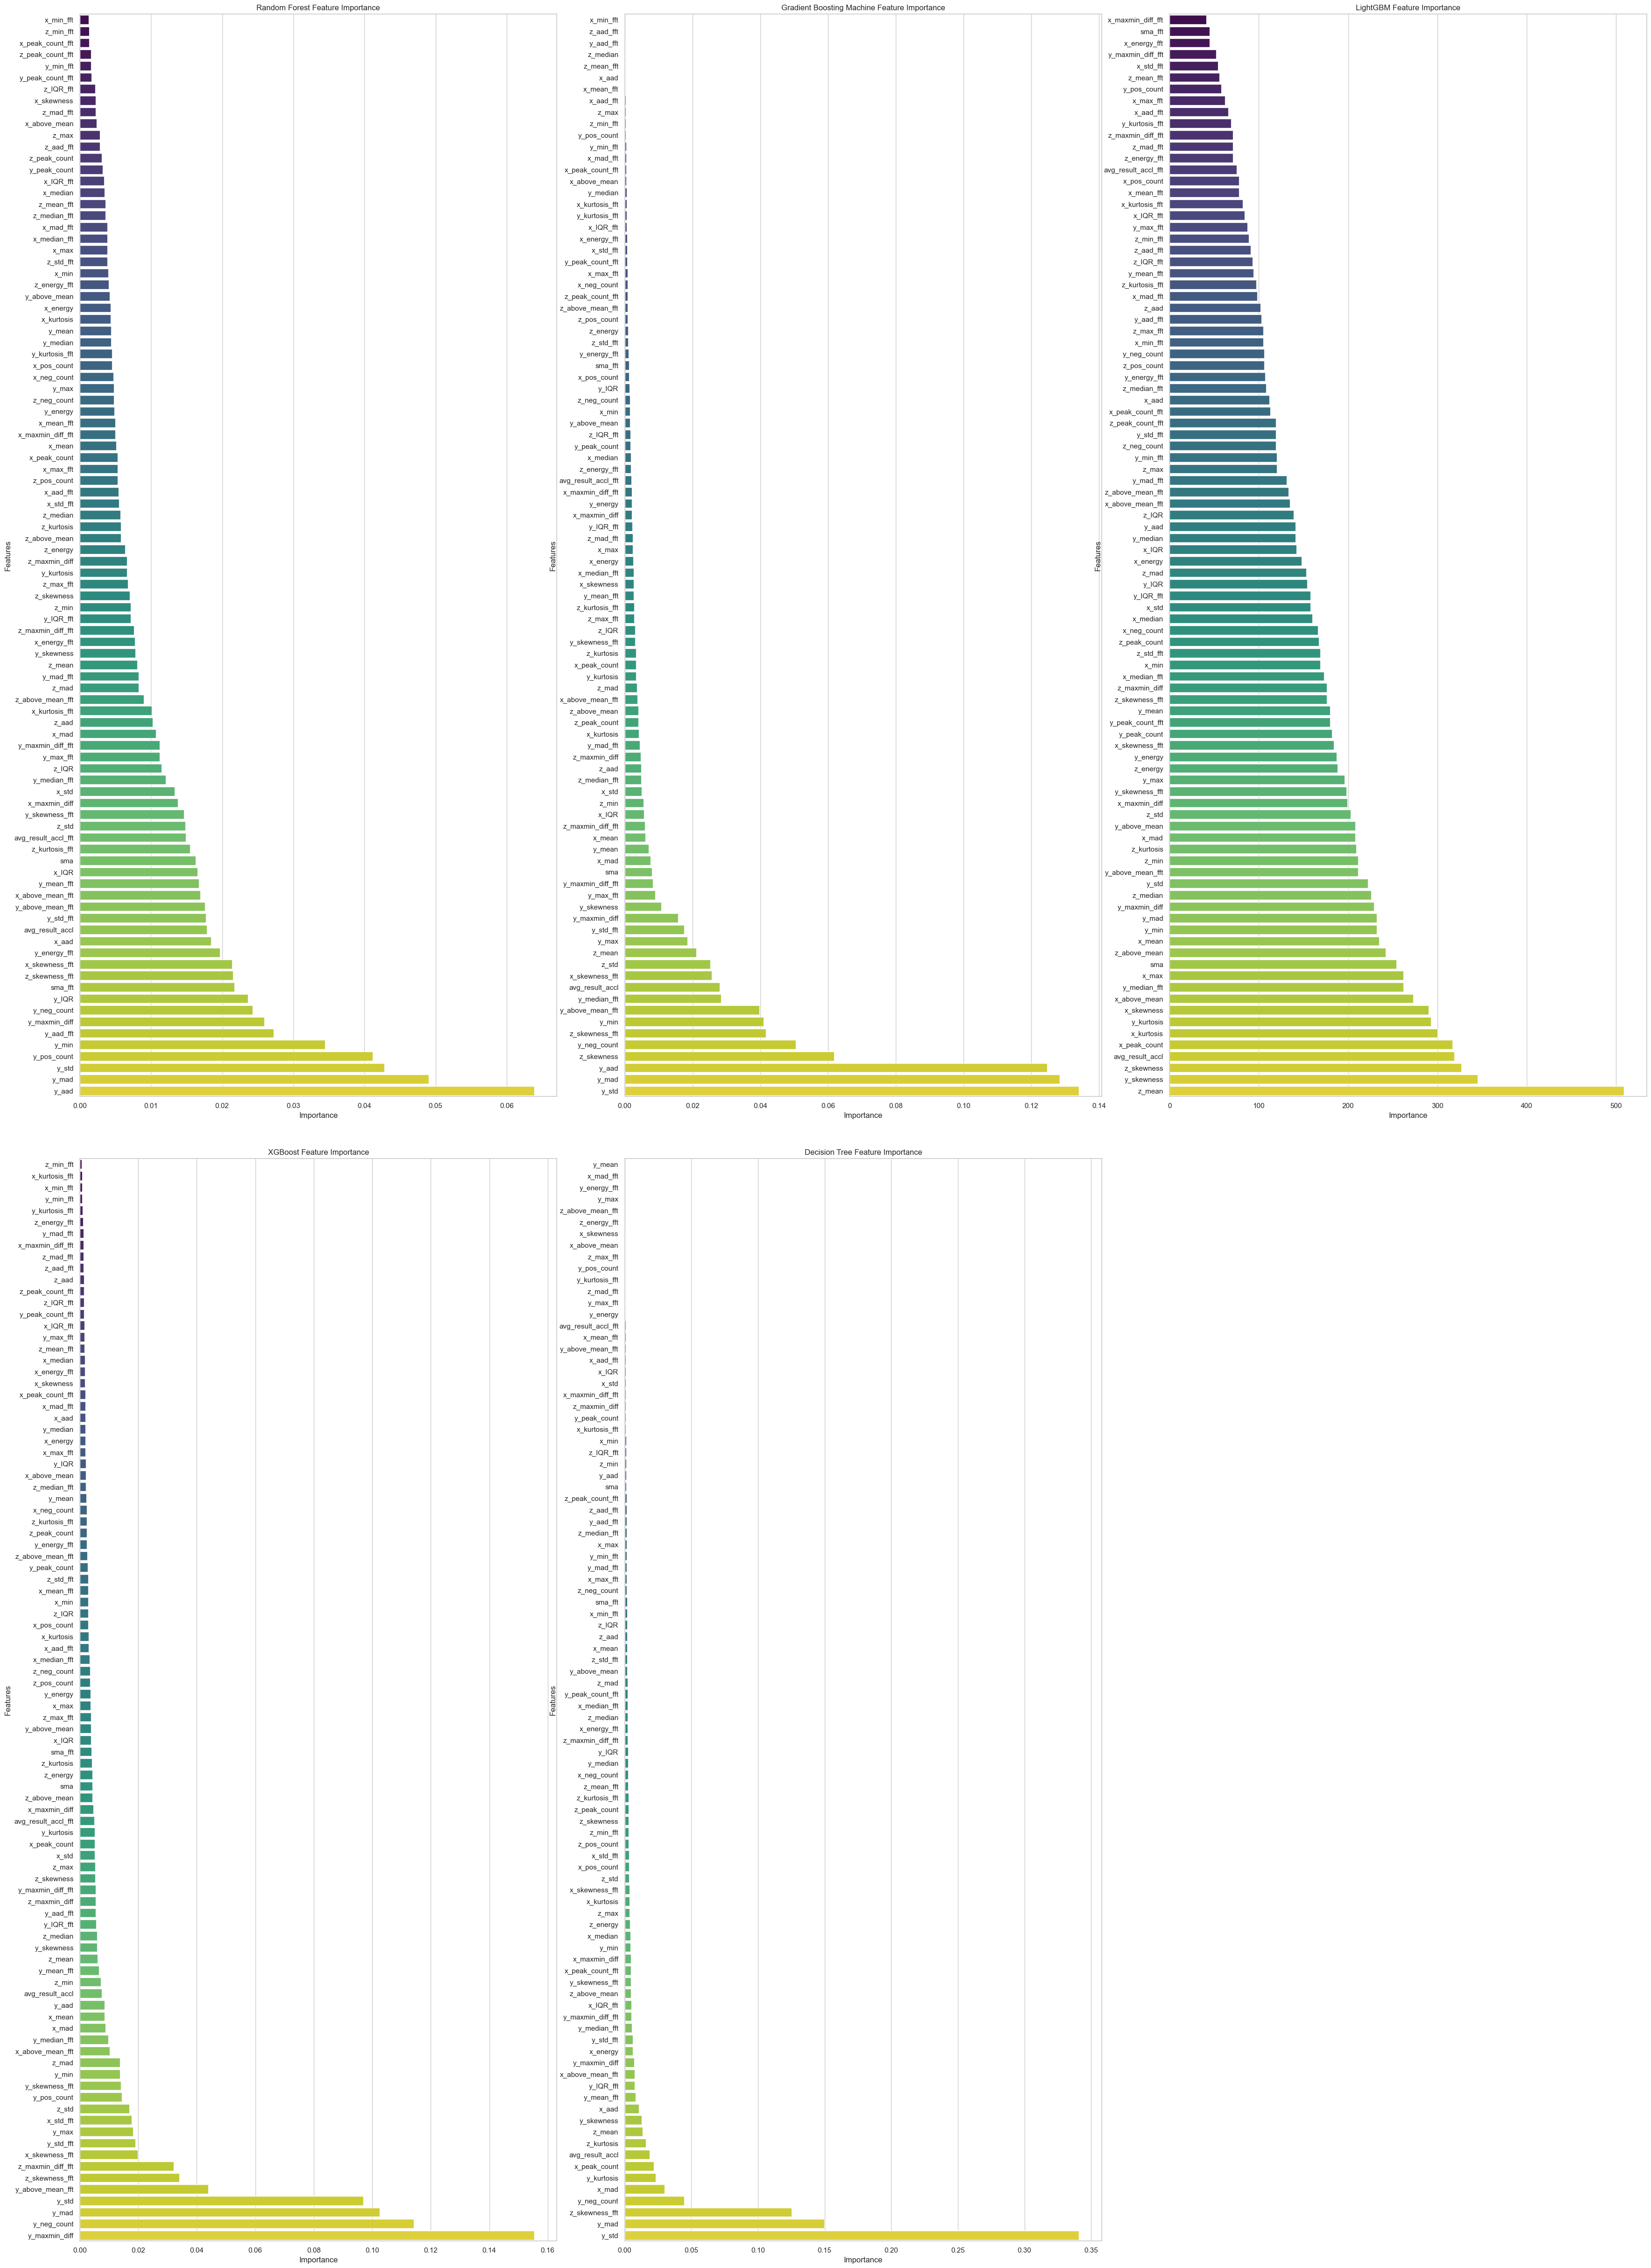

<Figure size 640x480 with 0 Axes>

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming X_train was your original DataFrame
feature_names = X_train.columns.tolist()

# Models and their names
models = [
    (rf, "Random Forest"),
    (gbm, "Gradient Boosting Machine"),
    (lvc, "LightGBM"),
    (xgb, "XGBoost"),
    (dt, "Decision Tree")
]

# Calculate rows and columns for subplots
n_models = len(models)
cols = 3  # up to 3 plots in a row
rows = np.ceil(n_models / cols).astype(int)

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plot feature importances
fig, axes = plt.subplots(rows, cols, figsize=(12 * cols, 25 * rows))
fig.tight_layout(pad=6.0)

# If there's only one model, make sure axes is iterable
if n_models == 1:
    axes = np.array([axes])

# Flatten the axes array for easy iteration if it's multidimensional
axes_flat = axes.flatten()

for ax, (model, name) in zip(axes_flat, models):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    sns.barplot(x=feature_importance[sorted_idx], y=np.array(feature_names)[sorted_idx], ax=ax, palette="viridis")
    ax.set_title(f'{name} Feature Importance')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Features')

# Hide any unused axes if the total number of models is not a multiple of the column count
for ax in axes_flat[n_models:]:
    ax.set_visible(False)

plt.show()
plt.tight_layout()

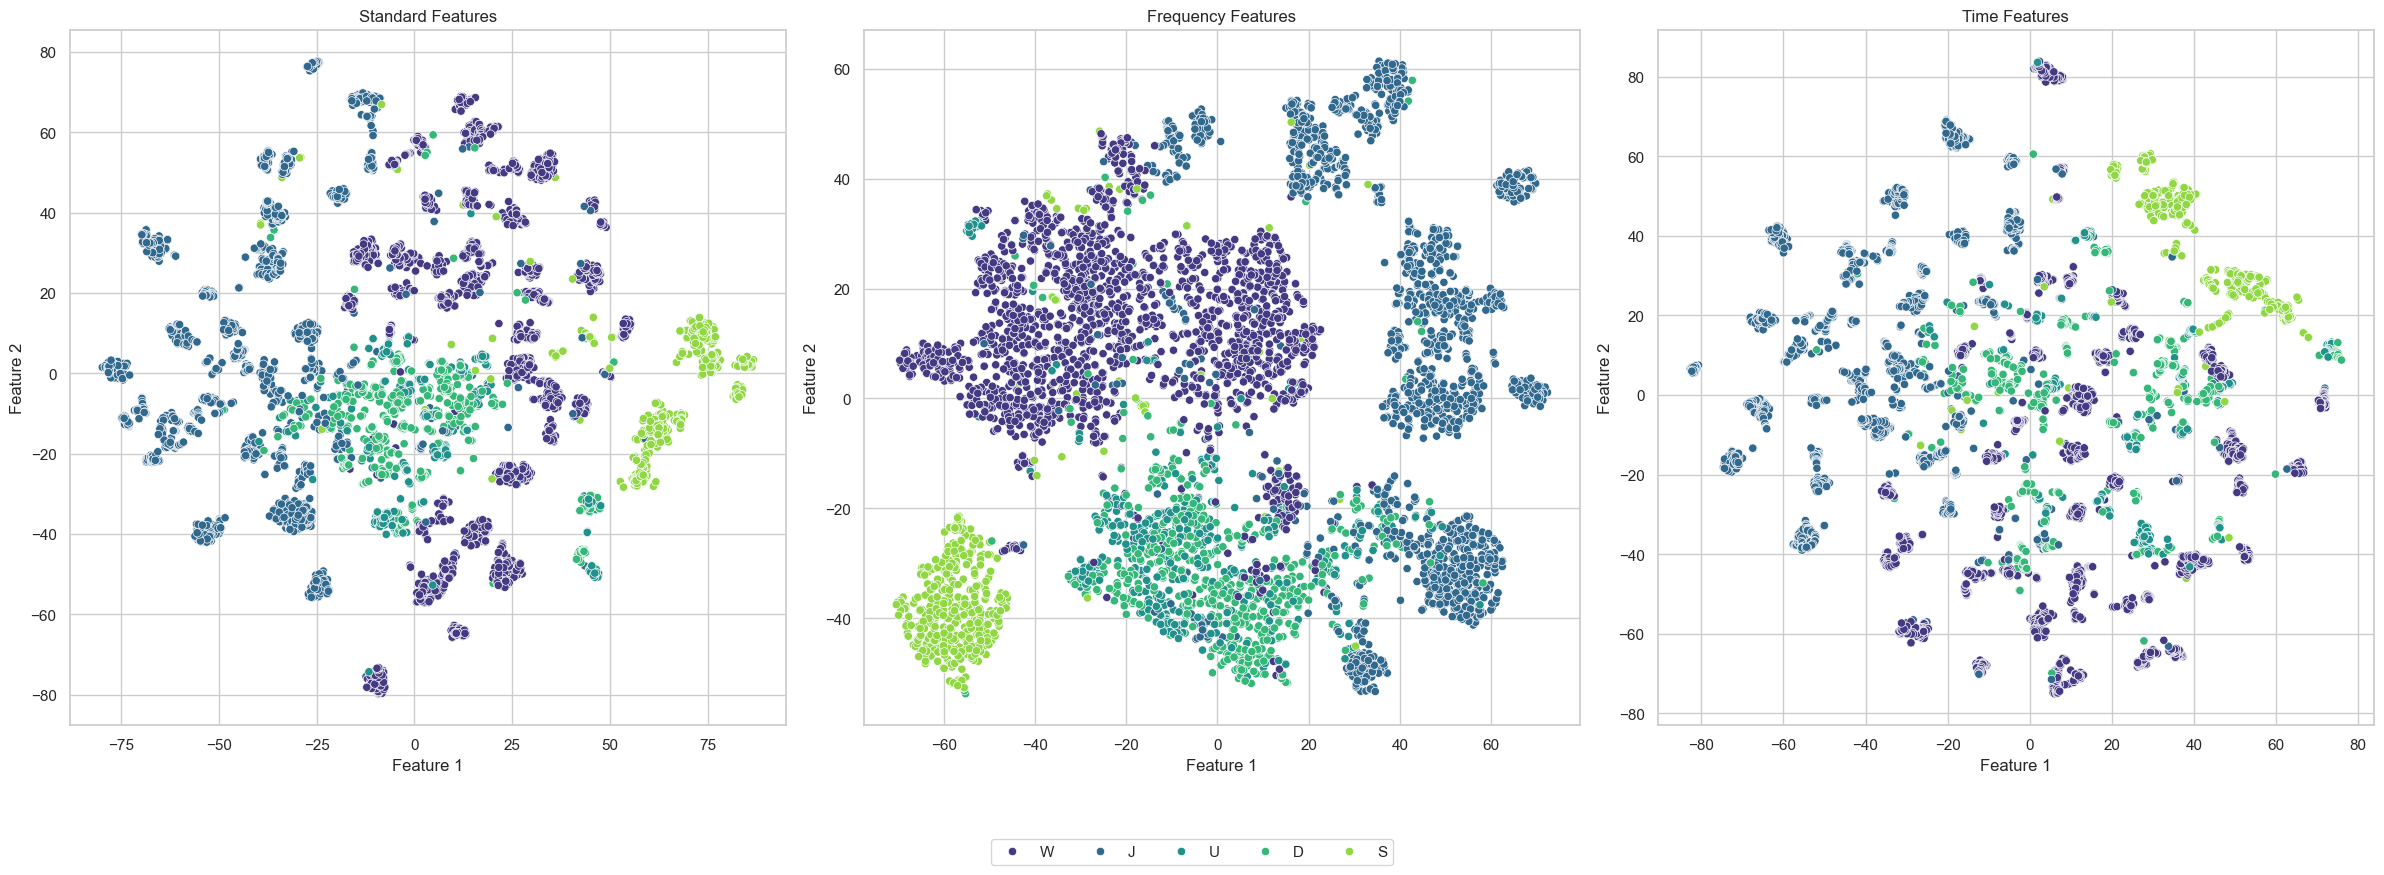

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE

# Define your datasets
datasets = [
    (X_train_std, 'Standard Features'),
    (X_train_freq_std, 'Frequency Features'),
    (X_train_time_std, 'Time Features')
]

# Start the figure
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
axes = axes.ravel()  # Flatten the axes array if needed

# Perform t-SNE and plot for each dataset
for i, (data, label) in enumerate(datasets):
    X_tsne = TSNE(n_components=2, random_state=21).fit_transform(data)
    tsne_df = pd.DataFrame({
        'Feature 1': X_tsne[:, 0],
        'Feature 2': X_tsne[:, 1],
        'Label': y_train_time  # Assuming this is your labels array
    })

    sns.scatterplot(ax=axes[i], data=tsne_df, x='Feature 1', y='Feature 2', hue='Label', palette='viridis')
    axes[i].set_title(label)
    axes[i].legend().remove()  # Remove the individual subplot legends

# Extract the handles and labels from any of the plots
handles, labels = axes[0].get_legend_handles_labels()

# Create a unified legend
fig.legend(handles, labels, loc='upper center', ncol=len(set(y_train_time)), bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()
